# Notebook for running multi-group sim with 8 groups for Cornell re-open

In [12]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

## Importing Params, setting up group sim

In [2]:
ug_dorm_params = load_params('../src/simulations_v2/params/baseline_testing/ug_dorm.yaml')[1]
ug_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/ug_off_campus.yaml')[1]
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/grad_research.yaml')[1]
gs_other_params = load_params('../src/simulations_v2/params/baseline_testing/grad_other.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [4]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [5]:
def run_multigroup_sim(sim, T):
    sim_dfs = sim.run_new_trajectory(112)
    inf_list = list()
    hosp_list = list()
    for df in sim_dfs:
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [6]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [7]:
limited_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/14,0],
[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
[2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0]]

In [9]:
interaction_matrix_v2 = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,3],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,3],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,3],
                               [0.011,0.026,0.106,0.016,0.174,0.092,0.231,3.5]])

results_faculty_ithaca = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v2, group_names, policy, 112, 50)
    results_faculty_ithaca.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [16]:
def generate_plotting_matrix(results_list):
    daily_tests = list()
    inf = list()
    inf_low = list()
    inf_high = list()
    hosp = list()
    hosp_low = list()
    hosp_high = list()
    cornell_inf = list()
    cornell_inf_low = list()
    cornell_inf_high = list()
    cornell_hosp = list()
    cornell_hosp_low = list()
    cornell_hosp_high = list()

    policy_ug_dorm = list()
    policy_ug_off_campus = list()
    policy_grad_research = list()
    policy_grad_other = list()
    policy_staff_student = list()
    policy_staff_non_student = list()
    policy_staff_off_campus = list()
    
    policies = list()
    
    for policy_dict in results_list:
        daily_tests.append(policy_dict['tests_per_day'])
        inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
        inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
        inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
        hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
        hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
        hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

        cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

        policy_ug_dorm.append(int(policy_dict['test_policy'][0]*7))
        policy_ug_off_campus.append(int(policy_dict['test_policy'][1]*7))
        policy_grad_research.append(int(policy_dict['test_policy'][2]*7))
        policy_grad_other.append(int(policy_dict['test_policy'][3]*7))
        policy_staff_student.append(int(policy_dict['test_policy'][4]*7))
        policy_staff_non_student.append(int(policy_dict['test_policy'][5]*7))
        policy_staff_off_campus.append(policy_dict['test_policy'][6]*7)
        
        test_policy_string = '['
        for frequency in policy_dict['test_policy'][:-2]:
            test_policy_string += str(int(frequency * 7)) + ','
        test_policy_string += str(np.round(policy[-2] * 7, 2))
        test_policy_string += ']'
        policies.append(test_policy_string)

    plotting_data = pd.DataFrame({'daily_tests': daily_tests, 'inf': inf, 'inf_low': inf_low, 'inf_high': inf_high, 'hosp': hosp,
                  'hosp_low': hosp_low, 'hosp_high': hosp_high, 'cornell_inf': cornell_inf, 'cornell_inf_low': cornell_inf_low,
                  'cornell_inf_high': cornell_inf_high, 'cornell_hosp': cornell_hosp, 'cornell_hosp_low': cornell_hosp_low,
                  'cornell_hosp_high': cornell_hosp_high, 'test_policy_ug_dorm': policy_ug_dorm,
                  'test_policy_ug_off_campus': policy_ug_off_campus,
                  'test_policy_grad_research': policy_grad_research, 'test_policy_grad_other': policy_grad_other,
                  'test_policy_staff_student': policy_staff_student,
                  'test_policy_staff_non_student': policy_staff_non_student,
                  'test_policy_staff_off_campus': policy_staff_off_campus,
                  'test_policy': policies})

    plotting_data['inf_yerr_low'] = plotting_data['inf'] - plotting_data['inf_low']
    plotting_data['inf_yerr_high'] = plotting_data['inf_high'] - plotting_data['inf']
    plotting_data['hosp_yerr_low'] = plotting_data['hosp'] - plotting_data['hosp_low']
    plotting_data['hosp_yerr_high'] = plotting_data['hosp_high'] - plotting_data['hosp']
    plotting_data['cornell_inf_yerr_low'] = plotting_data['cornell_inf'] - plotting_data['cornell_inf_low']
    plotting_data['cornell_inf_yerr_high'] = plotting_data['cornell_inf_high'] - plotting_data['cornell_inf']
    plotting_data['cornell_hosp_yerr_low'] = plotting_data['cornell_hosp'] - plotting_data['cornell_hosp_low']
    plotting_data['cornell_hosp_yerr_high'] = plotting_data['cornell_hosp_high'] - plotting_data['cornell_hosp']
    return plotting_data

In [17]:
plotting_data = generate_plotting_matrix(results_faculty_ithaca)

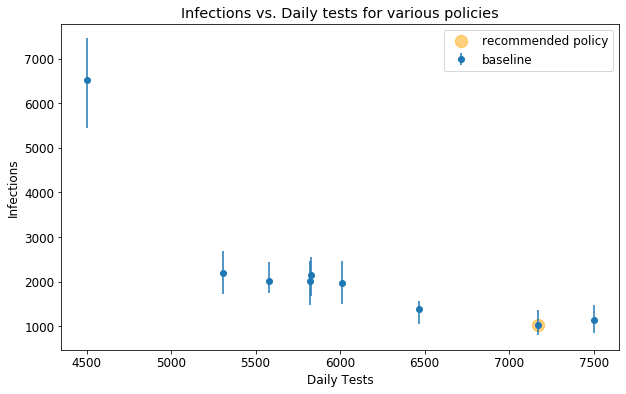

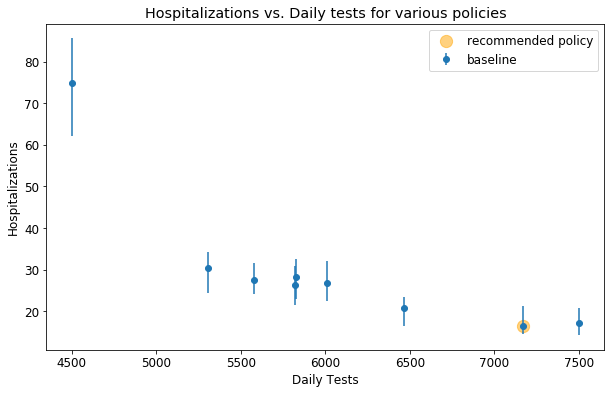

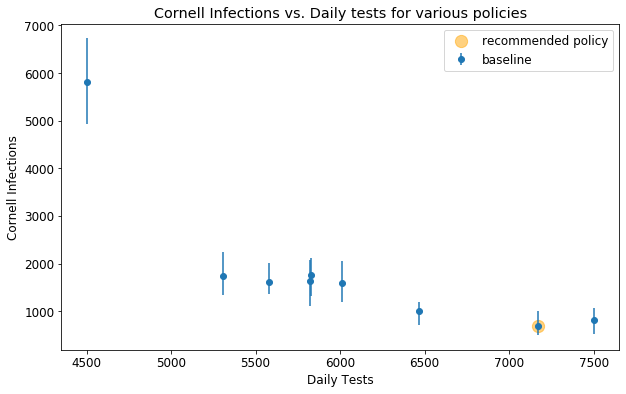

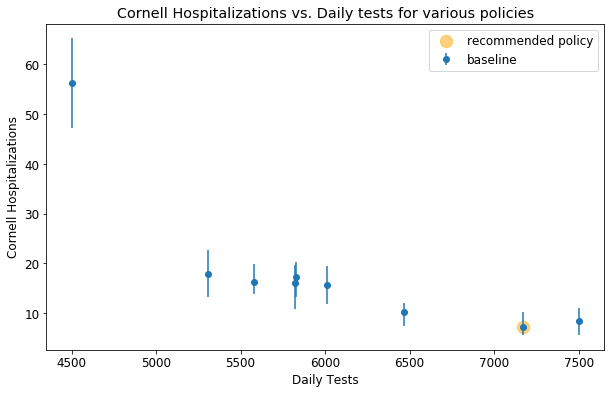

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data.head(9)['inf_yerr_low'],plotting_data.head(9)['inf_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Infections vs. Daily tests for various policies')
plt.ylabel('Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data.head(9)['hosp_yerr_low'],plotting_data.head(9)['hosp_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data.head(9)['cornell_inf_yerr_low'],plotting_data.head(9)['cornell_inf_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data.head(9)['cornell_hosp_yerr_low'],plotting_data.head(9)['cornell_hosp_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

In [ ]:
interaction_matrix_v3 = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,4.5],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,4.5],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,4.5],
                               [0.011,0.026,0.106,0.016,0.261,0.138,0.347,3.5]])

results_faculty_ithaca_3x = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v3, group_names, policy, 112, 50)
    results_faculty_ithaca_3x.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]


## Increasing Student->Student contact rates by 30%

In [20]:
interaction_matrix_v4 = np.array([[16.25,5.2,0.1,0.1,1,0.05,0.05,0.1],
                               [4.43,10.4,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,11.7,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,4.5],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,4.5],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,4.5],
                               [0.011,0.026,0.106,0.016,0.261,0.138,0.347,3.5]])

results_students_30 = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v4, group_names, policy, 112, 50)
    results_students_30.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857